In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import odc.geo.xr
import numpy as np

import xarray as xr
import dask
import dask.array as da
from dask.distributed import Client
import logging

from glob import glob
import os,sys

from pathlib import Path

from compute_solar import clear_sky_performance

In [2]:
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/REZ-boundaries.shx'
gdf = gpd.read_file(shapefile)
zones_to_ignore = [ # only wind farms in zone, no solar
    'Q1',
    'N7',
    'N8',
    'N10',
    'N11',
    'V3',
    'V4',
    'V7',
    'V8',
    'T4',
    'S1',
    'S3',
    'S4',
    'S5',
    'S10'
]

gdf = gdf[~gdf["Name"].str[:2].isin(zones_to_ignore)]

VIC = gdf[gdf["Name"].str.startswith("V")]

region = VIC

lon_min, lat_min, lon_max, lat_max = region.total_bounds

In [3]:
directory=Path('/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2023/07/01')
files = list(directory.rglob("*.nc"))
def _preprocess(ds):
    return ds[
    ['surface_global_irradiance', 'direct_normal_irradiance', 'surface_diffuse_irradiance']
    ].sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
ds = xr.open_mfdataset(files, preprocess=_preprocess)
ds = ds.chunk({'time':'auto', 'latitude':-1, 'longitude':-1})

In [4]:
mask = rasterio.features.geometry_mask(
            region.geometry,
            out_shape=ds.odc.geobox.shape,
            transform=ds.odc.geobox.affine,
            all_touched=False,
            invert=False)
mask = xr.DataArray(~mask, dims=('latitude', 'longitude'),coords=dict(
        longitude=ds.longitude,
        latitude=ds.latitude))

masked_ds = ds.where(mask, drop=True)

In [5]:
test_ds = masked_ds.isel(time=slice(51,52))

In [6]:
results = clear_sky_performance(test_ds)

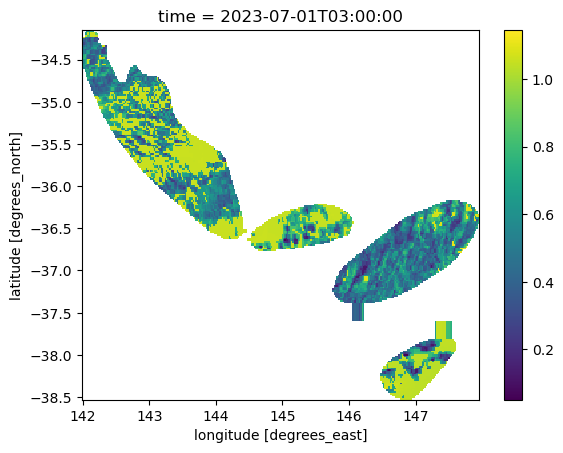

In [8]:
results.plot()

In [9]:
results

<xarray.DataArray (time: 1, latitude: 200, longitude: 294)> Size: 470kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan, 0.65827665, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.65783594, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2023-07-01T03:00:00
  * latitude   (latitude) float32 800B -38.52 -38.5 -38.48 ... -34.18 -34.16
  * longitude  (longitude) float32 1kB 142.0 142.0 142.0 ... 147.9 147.9 147.9